In [2]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_validate, ShuffleSplit, train_test_split
import pandas as pd
import data_pecarn 
import data_psrc
import data
from style import *
from collections import Counter
plt.style.use('dark_background')
# sns.set(style="white")
%matplotlib inline
%load_ext autoreload
%autoreload 2
NUM_PATIENTS = 12044

In [3]:
from data import feats_numerical, feats_categorical, meta

**load the data**

In [4]:
dummy = False
df_pecarn = data_pecarn.get_data(use_processed=False,
                                 frac_missing_allowed=0.1,
                                 dummy=dummy)
all_feats_pecarn, filtered_feats_pecarn = data.get_feat_names(df_pecarn)
df_psrc = data_psrc.get_data(use_processed=False, dummy=dummy)
all_feats_psrc, filtered_feats_psrc = data.get_feat_names(df_psrc)

# resulting features
outcome_def = 'iai_intervention' # output
common_feats = list(filtered_feats_pecarn.intersection(filtered_feats_psrc))
common_feats = common_feats + meta

feats_binary = [feat for feat in common_feats
                if not feat in feats_numerical + feats_categorical + meta]

computing pecarn preprocessing...
computing psrc preprocessing...


# see what feats matched / are missing

In [5]:
print('num features', len(common_feats) - len(meta))

num features 20


In [ ]:
for feat in common_feats:
    print(feat, '\t', df_pecarn[feat].min(), '\t', df_pecarn[feat].max())

**look at resulting feats**

In [ ]:
filtered_feats_pecarn.intersection(filtered_feats_psrc)

In [17]:
print('psrc but not pecarn')
filtered_feats_psrc.difference(filtered_feats_pecarn)

psrc but not pecarn


{'FemurFracture'}

In [18]:
print('pecarn but not psrc')
print(filtered_feats_pecarn.difference(filtered_feats_psrc))

pecarn but not psrc
{'ThoracicTender'}


# look for feat shift

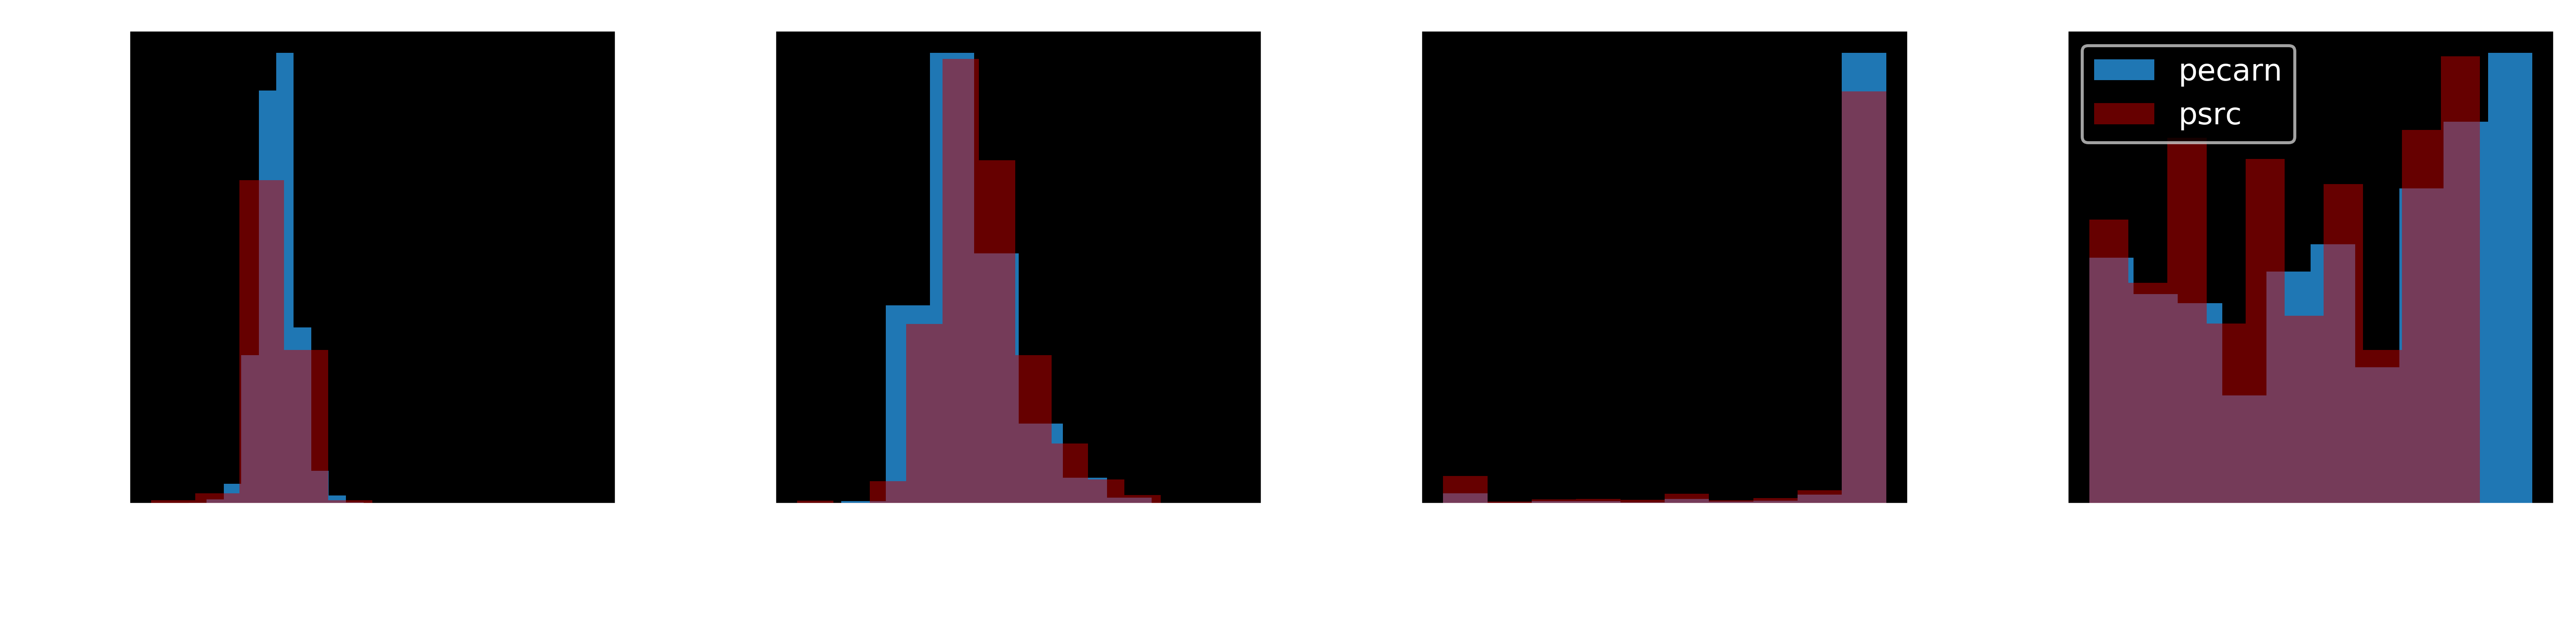

In [6]:
R, C, = 1, 4
plt.figure(figsize=(12, 3), dpi=500)
for i in range(len(feats_numerical)):
    plt.subplot(R, C, i + 1)
    feat = feats_numerical[i]
    plt.hist(df_pecarn[feat], density=True, alpha=1, label='pecarn', color=cb)
    plt.hist(df_psrc[feat], density=True, alpha=0.5, label='psrc', color=cr)
    plt.xlabel(feat, fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
R, C, = 1, 4
plt.figure(figsize=(12, 3), dpi=500)
# print(feats_categorical)
for i in range(len(feats_categorical)):
    plt.subplot(R, C, i + 1)
    feat = feats_categorical[i]
    plt.hist(df_pecarn[feat], density=True, alpha=1, label='pecarn', color=cb)
    plt.hist(df_psrc[feat], density=True, alpha=0.5, label='psrc', color=cr)
    plt.xticks(rotation='vertical')
    plt.title(feat)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
R, C = 3, 4
n = len(feats_binary)
def true_or_yes(vals):
    return (vals==True) | (vals=='yes')
frac_psrc = true_or_yes(df_psrc[feats_binary]).mean().values
frac_pecarn = true_or_yes(df_pecarn[feats_binary]).mean().values

width = 0.4
plt.figure(dpi=500, figsize=(3, 6))
plt.barh(np.arange(n), frac_pecarn, height=0.4, label='pecarn', color=cb)
plt.barh(np.arange(n) - width, frac_psrc, height=0.4, label='psrc', color=cr)
plt.yticks(np.arange(n) - width + 0.2, feats_binary)
plt.xlabel('fraction of patients which have this')
plt.legend()
plt.show()

**missing features**

In [ ]:
R, C = 3, 4
feats_all = [feat for feat in common_feats
         if not feat in meta]
n = len(feats_all)
frac_psrc = (df_psrc[feats_all]=='unknown').mean().values
frac_pecarn = (df_pecarn[feats_all]=='unknown').mean().values

width = 0.4
plt.figure(dpi=300, figsize=(3, 6))
plt.xlabel('Fraction of patients\nmissing this feature')
plt.barh(np.arange(n), frac_pecarn, height=0.4, label='pecarn', color=cb)
plt.barh(np.arange(n) - width, frac_psrc, height=0.4, label='psrc', color=cr)
plt.yticks(np.arange(n) - width + 0.2, feats_all)

plt.legend()
plt.show()

# write csvs

In [23]:
df_pecarn.astype('object').describe().transpose().to_csv('processed/pecarn_vars.csv')
df_psrc.astype('object').describe().transpose().to_csv('processed/psrc_vars.csv')

In [117]:
common_feats = [x for x in feat_names_pecarn if x in feat_names_psrc]

In [17]:
df_psrc['Emesis post injury'].unique()

array([ 0., nan,  1.])